In [1]:
import json
import os
import metrics
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
with open("./datasets/preprocessed2_aan.json") as f:
    aan_dataset = json.load(f)
    
len(aan_dataset)

15602

In [3]:
results_dir_path = './evaloffsets/'

In [4]:
result_data = {}
result_files = [f for f in os.listdir(results_dir_path) if '.json' in f]

for filename in result_files:
    split_name = filename.split('_')
    method_name = split_name[0] + '_' + split_name[1]
    result_type = split_name[2].split('.')[0]
    
    if method_name not in result_data:
        result_data[method_name] = {}
    
    with open(results_dir_path + filename) as file:
        result_data[method_name][result_type] = json.load(file)

In [19]:
for item in result_data.items():
    print('Method :', item[0])
    
    for subitem in item[1].items():
        print(subitem[0],':',str(len(subitem[1])),'records')
        
    print()

Method : base_bm25
gt : 3085 records
rec : 3085 records

Method : base_tfidfcosine
gt : 3085 records
rec : 3085 records

Method : base_personalizedpagerank
rec : 3030 records
gt : 3030 records

Method : base_doc2veccosine
gt : 3085 records
rec : 3085 records



# MAP, Recall and MRR

In [31]:
for result in tqdm(result_data.values()):
    gt_list = []
    rec_list = []
    
    for key in result['gt'].keys():
        if results['gt'][key]:
            gt_list.append(set(result['gt'][key]))
            rec_list.append(result['rec'][key])
            
    result['map_values'] = [metrics.mean_avg_precision_k(rec_list, gt_list, k+1) for k in range(100)]
    result['recall_values'] = [metrics.mean_recall_k(rec_list, gt_list, k+1) for k in range(100)]
    result['mrr_value'] = metrics.mean_reciprocal_rank(rec_list, gt_list)

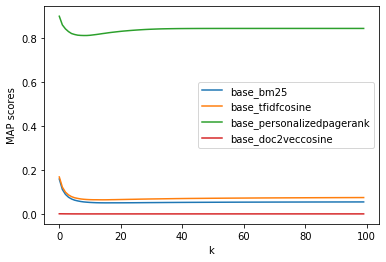

In [32]:
for method, result in result_data.items():
    plt.plot(result['map_values'], label=method)
    
plt.ylabel('MAP scores')
plt.xlabel('k')
plt.legend()
plt.show()

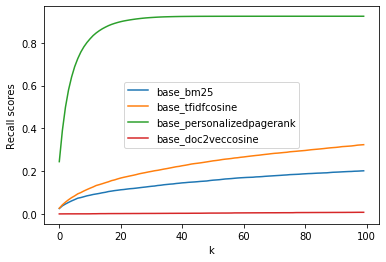

In [33]:
for method, result in result_data.items():
    plt.plot(result['recall_values'], label=method)
    
plt.ylabel('Recall scores')
plt.xlabel('k')
plt.legend()
plt.show()

In [34]:
print('MRR scores')
for item in result_data.items():
    print('Method :', item[0],'-->' , item[1]['mrr_value'])

MRR scores
Method : base_bm25 --> 0.2413233552076079
Method : base_tfidfcosine --> 0.2685863621340662
Method : base_personalizedpagerank --> 0.9451870187018703
Method : base_doc2veccosine --> 0.013324813686473369


# Item Coverage

In [47]:
print('Item Coverage')

for item in result_data.items():
    rec_items = set()
    
    for ref_ids in item[1]['rec'].values():
        for ref_id in ref_ids:
            rec_items.add(ref_id)
    
    print('Method :', item[0], '-->', str(len(rec_items) / len(aan_dataset)))

Item Coverage
Method : base_bm25 --> 0.7249711575439046
Method : base_tfidfcosine --> 0.7894500705037816
Method : base_personalizedpagerank --> 0.48974490449942315
Method : base_doc2veccosine --> 0.8022689398795027


# Dissimilarities

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [49]:
corpus = [ref['title'] + ' ' + ref['abstract'] for ref in aan_dataset]
vectorizer = TfidfVectorizer(stop_words='english').fit(corpus)

In [50]:
for ref in tqdm(aan_dataset):
    document = [ref['title'] + ' ' + ref['abstract']]
    ref['tfidf_vector'] = vectorizer.transform(document)

In [51]:
aan_dataset_dict = dict([(ref['id'], ref) for ref in aan_dataset])

In [55]:
for method in tqdm(result_data.values()):
    sim_infra_scores = []
    sim_user_scores = []
    
    for recs in tqdm(method['rec'].items()):
        target_ref_tfidf_vector = aan_dataset_dict[recs[0]]['tfidf_vector']
        ref_tfidf_vectors = [aan_dataset_dict[ref_id]['tfidf_vector'] for ref_id in recs[1]]
        for tfidf_vector in ref_tfidf_vectors:
            sim_user_scores.append(cosine_similarity(tfidf_vector, target_ref_tfidf_vector))
            
            # too long to compute... need to optimize, or change similarity method
            #for tfidf_vector2 in ref_tfidf_vectors:
            #    sim_infra_scores.append(cosine_similarity(tfidf_vector, tfidf_vector2))
    
    method['mean_sim_infra'] = np.mean(sim_infra_scores)
    method['mean_sim_user'] = np.mean(sim_user_scores)

/home/julien/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [60]:
print('Mean infra list similarity')
for item in result_data.items():
    print('Method :', item[0],'-->' , item[1]['mean_sim_infra'])

Mean infra list similarity
Method : base_bm25 --> nan
Method : base_tfidfcosine --> nan
Method : base_personalizedpagerank --> nan
Method : base_doc2veccosine --> nan


In [59]:
print('Mean similarity with user profil')
for item in result_data.items():
    print('Method :', item[0],'-->' , item[1]['mean_sim_user'])

Mean similarity with user profil
Method : base_bm25 --> 0.08524585339161897
Method : base_tfidfcosine --> 0.12552539986395223
Method : base_personalizedpagerank --> 0.03281853133362846
Method : base_doc2veccosine --> 0.01691199618758553


# Mean Average Shortest Path Length

In [5]:
import networkx as nx

In [6]:
citation_graph = nx.DiGraph()
for paper in aan_dataset:
    for ref_id in paper['references']:
        citation_graph.add_edge(paper['id'], ref_id)
        
len(citation_graph)

15602

In [ ]:
for result in tqdm(result_data.values()):
    result['mean_shortest_value'] = metrics.mean_avg_shortest_path_length(citation_graph, result['rec'].values())

In [ ]:
# too long to compute..., need to optimize

In [ ]:
print('Mean Average Shortest Path Length')
for item in result_data.items():
    print('Method :', item[0],'-->' , item[1]['mean_shortest_value'])